# Measuring Synaptic Strength

In this notebook we use the [Allen Institute synaptic physiology dataset](https://portal.brain-map.org/explore/connectivity/synaptic-physiology) to measure the strength of synaptic connections and the relationship to cell subclass.

For an introduction to the Jupyter Notebook interface interface, try [Codeacademy: How To Use Jupyter Notebooks]( https://www.codecademy.com/articles/how-to-use-jupyter-notebooks) or [Jupyter Notebook Quick Start Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html).


In [1]:
import numpy as np
from aisynphys.database import SynphysDatabase
from aisynphys.cell_class import CellClass

In [2]:
# Download and cache the sqlite file for the requested database
#   (for available versions, see SynphysDatabase.list_versions)
db = SynphysDatabase.load_version('synphys_r1.0_2019-08-29_small.sqlite')

We are going to compare the strength of excitatory connectivity onto the three inhibitory cell subclassess -- Pvalb, Sst, and Vip.

Begin by defining these subclasses:

In [3]:
post_classes = {
    'pvalb': CellClass(cre_type='pvalb'),
    'sst': CellClass(cre_type='sst'),
    'vip': CellClass(cre_type='vip'),
}

Query the database to get all excitatory synapses with a specific postsynaptic cre type. We also filter here for specific project names "mouse V1 coarse matrix" and "mouse V1 pre production" in order to exclude other experiment types.

In [4]:
# query once for each postsynaptic type, building up a Pandas dataframe

pairs = None
for name, post_class in post_classes.items():
    pair_query = db.pair_query(
        project_name=["mouse V1 coarse matrix", "mouse V1 pre production"],
        post_class=post_class,
        synapse=True,
        synapse_type='ex',
    )
    pair_query = pair_query.add_columns(
        db.Synapse.psp_amplitude,
        db.Dynamics.pulse_amp_90th_percentile,
    )
    df = pair_query.dataframe()
    df['post_class'] = name
    if pairs is None:
        pairs = df
    else:
        pairs = pairs.append(df)
    print("%s: %d synapses" % (name, len(df)))

pvalb: 90 synapses
sst: 71 synapses
vip: 24 synapses


In [5]:
# we now have all synapses loaded into one dataframe:
pairs.head()

,id,experiment_id,pre_cell_id,post_cell_id,has_synapse,has_electrical,crosstalk_artifact,n_ex_test_spikes,n_in_test_spikes,distance,meta,psp_amplitude,pulse_amp_90th_percentile,post_class
0,43122,1235,7375,7370,True,False,None,12,0,0.000058,None,NaN,NaN,pvalb
1,44106,1264,7546,7550,True,False,None,484,60,0.000052,None,0.000436,0.000848,pvalb
2,44111,1264,7547,7550,True,False,None,196,60,0.000085,None,NaN,NaN,pvalb
3,44116,1264,7548,7550,True,False,None,648,60,0.000110,None,NaN,NaN,pvalb
4,44412,1279,7617,7621,True,False,None,480,480,0.000226,None,0.000101,0.000864,pvalb


In [6]:
avg_psp_amp = pairs.groupby('post_class').psp_amplitude.mean()
for name in post_classes:
    print("Average PSP amplitude for pyr->%s: %0.2f mV" % (name, avg_psp_amp[name]*1e3))

Average PSP amplitude for pyr->pvalb: 0.54 mV
Average PSP amplitude for pyr->sst: 0.28 mV
Average PSP amplitude for pyr->vip: 0.51 mV


The strength of signaling for any synapse changes dynamically based on its prior history and stochastically with each presynaptic spike. Because of this dynamic nature, there is not always an obvious way to describe the "strength" of a synapse as a single value. Above, we show the _resting state_ PSP amplitude, which is averaged over PSPs that were evoked after a period of several seconds of quiescence. 

It appears from this metric that Sst cells receive much weaker excitation than Pvalb and Vip cells. Let's look closer at the distributions beind those values:

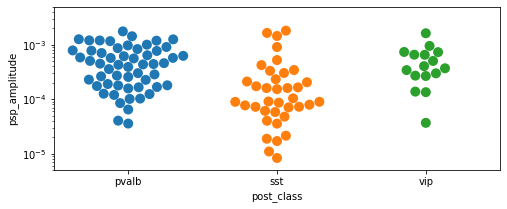

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig,ax = plt.subplots(figsize=(8, 3))
ax.set_yscale('log')
ax.set_ylim(5e-6, 5e-3)
sns.swarmplot(x="post_class", y="psp_amplitude", data=pairs, ax=ax, size=10)

The distributions above seem to confirm the initial suggestion that Sst cells receive weaker excitation (note the semilog scale). However, excitatory connections onto Sst cells are also known to be strongly _facilitating_, which means that we expect these connections to appear weakest in the quiescent state measured above. 

Another way to measure synaptic strength is to estimate the maximum PSP amplitude _regardless of prior activity_. We use the 90th percentile PSP amplitude for this purpose, and below it appears that the 3 subclasses have much more comparable levels of excitation under this metric:

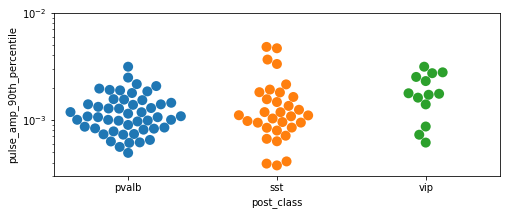

In [8]:
fig,ax = plt.subplots(figsize=(8, 3))
ax.set_yscale('log')
ax.set_ylim(300e-6, 10e-3)
sns.swarmplot(x="post_class", y="pulse_amp_90th_percentile", data=pairs, ax=ax, size=10)